In [1]:
%% Set up the Import Options and import the data
opts = delimitedTextImportOptions("NumVariables", 8);
% Specify range and delimiter
opts.DataLines = [2, Inf];
opts.Delimiter = ",";
% Specify column names and types
opts.VariableNames = ["Ticker", "Time", "Open", "High", "Low", "Close", "Volume", "OpenInterest"];
opts.VariableTypes = ["categorical", "datetime", "double", "double", "double", "double", "double", "double"];
% Specify file level properties
opts.ExtraColumnsRule = "ignore";
opts.EmptyLineRule = "read";
% Specify variable properties
opts = setvaropts(opts, "Ticker", "EmptyFieldRule", "auto");
opts = setvaropts(opts, "Time", "InputFormat", "MM/dd/yyyy HH:mm");
% Import the data
FPT = readtimetable("/FPT.csv", opts, "RowTimes", "Time");
%% Clear temporary variables
clear opts

In [2]:
S = vartype('numeric');
% TT2 is timetable
TT2 = FPT(:,S);
TT2 = TT2(:,1:end-1);

In [3]:
numObservations = numel(TT2(:,"Open"));
idxTrain = 1:floor(0.9*numObservations);
idxTest = floor(0.9*numObservations)+1:numObservations;
dataTrain = TT2(idxTrain,:);
dataTest = TT2(idxTest,:);

In [6]:
XTrain = dataTrain(1:end-1,:);
YTrain = dataTrain(2:end,:);

In [7]:
numFeatures = size(XTrain,2);
numSamples = size(XTrain,1);

In [8]:
muX = mean(cat(2,XTrain),1);
sigmaX = std(cat(2,XTrain),0,1);
muY = mean(cat(2,YTrain),1);
sigmaY = std(cat(2,YTrain),0,1);
XTrain = (XTrain - muX) ./ sigmaX;
YTrain = (YTrain - muY) ./ sigmaY;

In [9]:
XTrain = table2array(XTrain);
YTrain = table2array(YTrain);

In [10]:
XTrain = XTrain';
YTrain = YTrain';

In [11]:
XTrain(end, end, 2) = 0;
YTrain(end, end, 2) = 0;

In [12]:
XTrain = permute(XTrain,[3,2,1]);
YTrain = permute(YTrain,[3,2,1]);

In [14]:
filename = "training_data.mat";
save(filename,"XTrain","YTrain")

In [4]:
numHiddenUnits = 200;
numFeatures = 5;
layers = [
    sequenceInputLayer(numFeatures)
    lstmLayer(numHiddenUnits,OutputMode="sequence")
    fullyConnectedLayer(numFeatures)
    regressionLayer];
lgraph = layerGraph(layers);

In [5]:
exportNetworkToTensorFlow(lgraph,"./myModel")

In [1]:
import myModel
model = myModel.load_model()
model.summary()

2024-04-03 08:45:35.946939: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 08:45:36.973581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 08:45:36.979174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 08:45:39.107279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-03 08:45:41.501651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 5)]         0         
                                                                 
 lstm_ (LSTM)                (None, None, 200)         164800    
                                                                 
 fc_ (Dense)                 (None, None, 5)           1005      
                                                                 
Total params: 165805 (647.68 KB)
Trainable params: 165805 (647.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [1]:
import scipy.io as sio
data = sio.loadmat("training_data.mat")
XTrain = data["XTrain"]
YTrain = data["YTrain"]

In [2]:
print(XTrain.shape)
print(YTrain.shape)

(2, 87664, 5)
(2, 87664, 5)


In [3]:
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import Huber

2024-04-08 17:44:01.898544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:44:02.909754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:44:02.913619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 17:44:05.122228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
ch = ModelCheckpoint(filepath = 'model', monitor = 'mean_absolute_error', verbose = 1, mode = 'min',  
                     save_best_only = True, save_weights_only = False)
model.compile(optimizer = "adam", loss = Huber(delta=1.5), metrics=["mean_absolute_error"])
r = model.fit(XTrain, YTrain, epochs=100, batch_size=16, verbose = 1, callbacks = [ch])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0698
Epoch 1: mean_absolute_error improved from inf to 0.06978, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 150s 150s/step - loss: 0.0231 - mean_absolute_error: 0.0698
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0723
Epoch 2: mean_absolute_error did not improve from 0.06978
1/1 [==============================] - 161s 161s/step - loss: 0.0232 - mean_absolute_error: 0.0723
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0697
Epoch 3: mean_absolute_error improved from 0.06978 to 0.06968, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 154s 154s/step - loss: 0.0232 - mean_absolute_error: 0.0697
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.0221 - mean_absolute_error: 0.0571
Epoch 4: mean_absolute_error improved from 0.06968 to 0.05711, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 143s 143s/step - loss: 0.0221 - mean_absolute_error: 0.0571
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.0592
Epoch 5: mean_absolute_error did not improve from 0.05711
1/1 [==============================] - 146s 146s/step - loss: 0.0220 - mean_absolute_error: 0.0592
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.0663
Epoch 6: mean_absolute_error did not improve from 0.05711
1/1 [==============================] - 144s 144s/step - loss: 0.0224 - mean_absolute_error: 0.0663
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.0637
Epoch 7: mean_absolute_error did not improve from 0.05711
1/1 [==============================] - 152s 152s/step - loss: 0.0223 - mean_absolute_error: 0.0637
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0580
Epoch 8: mean_

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 148s 148s/step - loss: 0.0217 - mean_absolute_error: 0.0525
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0532
Epoch 10: mean_absolute_error did not improve from 0.05249
1/1 [==============================] - 147s 147s/step - loss: 0.0217 - mean_absolute_error: 0.0532
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0567
Epoch 11: mean_absolute_error did not improve from 0.05249
1/1 [==============================] - 162s 162s/step - loss: 0.0219 - mean_absolute_error: 0.0567
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0590
Epoch 12: mean_absolute_error did not improve from 0.05249
1/1 [==============================] - 143s 143s/step - loss: 0.0219 - mean_absolute_error: 0.0590
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.0560
Epoch 1

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 154s 154s/step - loss: 0.0216 - mean_absolute_error: 0.0501
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0493
Epoch 15: mean_absolute_error improved from 0.05005 to 0.04927, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 152s 152s/step - loss: 0.0215 - mean_absolute_error: 0.0493
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.0527
Epoch 16: mean_absolute_error did not improve from 0.04927
1/1 [==============================] - 145s 145s/step - loss: 0.0216 - mean_absolute_error: 0.0527
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0543
Epoch 17: mean_absolute_error did not improve from 0.04927
1/1 [==============================] - 150s 150s/step - loss: 0.0217 - mean_absolute_error: 0.0543
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0538
Epoch 18: mean_absolute_error did not improve from 0.04927
1/1 [==============================] - 149s 149s/step - loss: 0.0217 - mean_absolute_error: 0.0538
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.0524
Epoch 1

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 164s 164s/step - loss: 0.0215 - mean_absolute_error: 0.0486
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0502
Epoch 22: mean_absolute_error did not improve from 0.04859
1/1 [==============================] - 145s 145s/step - loss: 0.0215 - mean_absolute_error: 0.0502
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.0513
Epoch 23: mean_absolute_error did not improve from 0.04859
1/1 [==============================] - 153s 153s/step - loss: 0.0216 - mean_absolute_error: 0.0513
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0510
Epoch 24: mean_absolute_error did not improve from 0.04859
1/1 [==============================] - 152s 152s/step - loss: 0.0215 - mean_absolute_error: 0.0510
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0498
Epoch 2

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0214 - mean_absolute_error: 0.0486
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0480
Epoch 27: mean_absolute_error improved from 0.04857 to 0.04796, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 152s 152s/step - loss: 0.0214 - mean_absolute_error: 0.0480
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0484
Epoch 28: mean_absolute_error did not improve from 0.04796
1/1 [==============================] - 150s 150s/step - loss: 0.0214 - mean_absolute_error: 0.0484
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0493
Epoch 29: mean_absolute_error did not improve from 0.04796
1/1 [==============================] - 151s 151s/step - loss: 0.0215 - mean_absolute_error: 0.0493
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0492
Epoch 30: mean_absolute_error did not improve from 0.04796
1/1 [==============================] - 152s 152s/step - loss: 0.0214 - mean_absolute_error: 0.0492
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0480
Epoch 3

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 151s 151s/step - loss: 0.0214 - mean_absolute_error: 0.0471
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0473
Epoch 33: mean_absolute_error did not improve from 0.04705
1/1 [==============================] - 152s 152s/step - loss: 0.0214 - mean_absolute_error: 0.0473
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0477
Epoch 34: mean_absolute_error did not improve from 0.04705
1/1 [==============================] - 152s 152s/step - loss: 0.0214 - mean_absolute_error: 0.0477
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0477
Epoch 35: mean_absolute_error did not improve from 0.04705
1/1 [==============================] - 149s 149s/step - loss: 0.0214 - mean_absolute_error: 0.0477
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0475
Epoch 3

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 157s 157s/step - loss: 0.0214 - mean_absolute_error: 0.0468
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0463
Epoch 38: mean_absolute_error improved from 0.04677 to 0.04626, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 152s 152s/step - loss: 0.0214 - mean_absolute_error: 0.0463
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0467
Epoch 39: mean_absolute_error did not improve from 0.04626
1/1 [==============================] - 148s 148s/step - loss: 0.0214 - mean_absolute_error: 0.0467
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0472
Epoch 40: mean_absolute_error did not improve from 0.04626
1/1 [==============================] - 148s 148s/step - loss: 0.0214 - mean_absolute_error: 0.0472
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0471
Epoch 41: mean_absolute_error did not improve from 0.04626
1/1 [==============================] - 155s 155s/step - loss: 0.0214 - mean_absolute_error: 0.0471
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0466
Epoch 4

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0461
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0459
Epoch 44: mean_absolute_error improved from 0.04612 to 0.04594, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 150s 150s/step - loss: 0.0213 - mean_absolute_error: 0.0459
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0462
Epoch 45: mean_absolute_error did not improve from 0.04594
1/1 [==============================] - 149s 149s/step - loss: 0.0213 - mean_absolute_error: 0.0462
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0466
Epoch 46: mean_absolute_error did not improve from 0.04594
1/1 [==============================] - 147s 147s/step - loss: 0.0213 - mean_absolute_error: 0.0466
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0465
Epoch 47: mean_absolute_error did not improve from 0.04594
1/1 [==============================] - 149s 149s/step - loss: 0.0213 - mean_absolute_error: 0.0465
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0460
Epoch 4

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0456
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0456
Epoch 50: mean_absolute_error did not improve from 0.04563
1/1 [==============================] - 147s 147s/step - loss: 0.0213 - mean_absolute_error: 0.0456
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0457
Epoch 51: mean_absolute_error did not improve from 0.04563
1/1 [==============================] - 151s 151s/step - loss: 0.0213 - mean_absolute_error: 0.0457
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0458
Epoch 52: mean_absolute_error did not improve from 0.04563
1/1 [==============================] - 142s 142s/step - loss: 0.0213 - mean_absolute_error: 0.0458
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0458
Epoch 5

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 160s 160s/step - loss: 0.0213 - mean_absolute_error: 0.0455
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0454
Epoch 55: mean_absolute_error improved from 0.04550 to 0.04543, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 149s 149s/step - loss: 0.0213 - mean_absolute_error: 0.0454
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0455
Epoch 56: mean_absolute_error did not improve from 0.04543
1/1 [==============================] - 152s 152s/step - loss: 0.0213 - mean_absolute_error: 0.0455
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0455
Epoch 57: mean_absolute_error did not improve from 0.04543
1/1 [==============================] - 150s 150s/step - loss: 0.0213 - mean_absolute_error: 0.0455
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0454
Epoch 58: mean_absolute_error improved from 0.04543 to 0.04536, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 157s 157s/step - loss: 0.0213 - mean_absolute_error: 0.0454
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 59: mean_absolute_error improved from 0.04536 to 0.04524, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 154s 154s/step - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 60: mean_absolute_error improved from 0.04524 to 0.04514, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 61: mean_absolute_error did not improve from 0.04514
1/1 [==============================] - 145s 145s/step - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 62: mean_absolute_error did not improve from 0.04514
1/1 [==============================] - 152s 152s/step - loss: 0.0213 - mean_absolute_error: 0.0452
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 63: mean_absolute_error improved from 0.04514 to 0.04507, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0450
Epoch 64: mean_absolute_error improved from 0.04507 to 0.04503, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 151s 151s/step - loss: 0.0213 - mean_absolute_error: 0.0450
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 65: mean_absolute_error did not improve from 0.04503
1/1 [==============================] - 181s 181s/step - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 66: mean_absolute_error did not improve from 0.04503
1/1 [==============================] - 160s 160s/step - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 67: mean_absolute_error did not improve from 0.04503
1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0451
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0450
Epoch 6

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 151s 151s/step - loss: 0.0213 - mean_absolute_error: 0.0450
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 69: mean_absolute_error improved from 0.04497 to 0.04484, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 157s 157s/step - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 70: mean_absolute_error improved from 0.04484 to 0.04477, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 162s 162s/step - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 71: mean_absolute_error did not improve from 0.04477
1/1 [==============================] - 149s 149s/step - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 72: mean_absolute_error improved from 0.04477 to 0.04476, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 167s 167s/step - loss: 0.0213 - mean_absolute_error: 0.0448
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 73: mean_absolute_error improved from 0.04476 to 0.04471, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 155s 155s/step - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 74: mean_absolute_error improved from 0.04471 to 0.04468, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 158s 158s/step - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 75: mean_absolute_error did not improve from 0.04468
1/1 [==============================] - 151s 151s/step - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 76: mean_absolute_error did not improve from 0.04468
1/1 [==============================] - 150s 150s/step - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 77: mean_absolute_error did not improve from 0.04468
1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0447
Epoch 7

INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 155s 155s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 81: mean_absolute_error improved from 0.04464 to 0.04462, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 160s 160s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 82: mean_absolute_error improved from 0.04462 to 0.04460, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 152s 152s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 83: mean_absolute_error improved from 0.04460 to 0.04458, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 163s 163s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 84: mean_absolute_error improved from 0.04458 to 0.04456, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 172s 172s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 85: mean_absolute_error improved from 0.04456 to 0.04456, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 161s 161s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 86: mean_absolute_error improved from 0.04456 to 0.04456, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 156s 156s/step - loss: 0.0213 - mean_absolute_error: 0.0446
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 87: mean_absolute_error improved from 0.04456 to 0.04454, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 161s 161s/step - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 88: mean_absolute_error improved from 0.04454 to 0.04451, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 150s 150s/step - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 89: mean_absolute_error improved from 0.04451 to 0.04450, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 153s 153s/step - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 90: mean_absolute_error improved from 0.04450 to 0.04449, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 160s 160s/step - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 91: mean_absolute_error improved from 0.04449 to 0.04447, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 155s 155s/step - loss: 0.0213 - mean_absolute_error: 0.0445
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 92: mean_absolute_error improved from 0.04447 to 0.04445, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 160s 160s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 93: mean_absolute_error improved from 0.04445 to 0.04443, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 157s 157s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 94: mean_absolute_error improved from 0.04443 to 0.04443, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 159s 159s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 95: mean_absolute_error did not improve from 0.04443
1/1 [==============================] - 152s 152s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 96: mean_absolute_error improved from 0.04443 to 0.04442, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 161s 161s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 97: mean_absolute_error improved from 0.04442 to 0.04439, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 154s 154s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 98: mean_absolute_error improved from 0.04439 to 0.04436, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 150s 150s/step - loss: 0.0213 - mean_absolute_error: 0.0444
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0443
Epoch 99: mean_absolute_error improved from 0.04436 to 0.04434, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 152s 152s/step - loss: 0.0213 - mean_absolute_error: 0.0443
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mean_absolute_error: 0.0443
Epoch 100: mean_absolute_error improved from 0.04434 to 0.04433, saving model to model
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 164s 164s/step - loss: 0.0213 - mean_absolute_error: 0.0443


In [9]:
sio.savemat("training_history.mat",{"training_history":r.history})

In [1]:
load("training_history.mat")
history = struct(training_history)

history = struct with fields:
                   loss: [0.0231 0.0232 0.0232 0.0221 ... ] (1x100 double)
    mean_absolute_error: [0.0698 0.0723 0.0697 0.0571 ... ] (1x100 double)

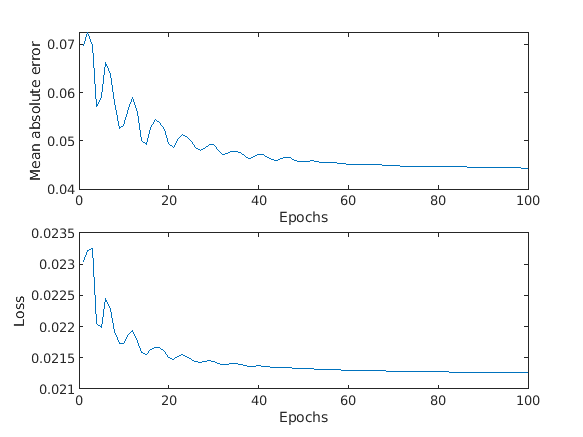

In [2]:
tiledlayout(2,1,TileSpacing="tight")

nexttile
plot(history.mean_absolute_error)
xlabel("Epochs")
ylabel("Mean absolute error")

nexttile
plot(history.loss)
xlabel("Epochs")
ylabel("Loss")

In [5]:
XTest = dataTest(1:end-1,:);
YTest = dataTest(2:end,:);

In [6]:
muX_Test = mean(cat(2,XTest),1);
sigmaX_Test = std(cat(2,XTest),0,1);
muT_Test = mean(cat(2,YTest),1);
sigmaT_Test = std(cat(2,YTest),0,1);
XTest = (XTest - muX_Test) ./ sigmaX_Test;
YTest = (YTest - muT_Test) ./ sigmaT_Test;

In [7]:
XTest = table2array(XTest);
YTest = table2array(YTest);

In [4]:
XTest = XTest';
YTest = YTest';

In [5]:
XTest(end, end, 2) = 0;
YTest(end, end, 2) = 0;

In [6]:
XTest = permute(XTest,[3,2,1]);
YTest = permute(YTest,[3,2,1]);

In [ ]:
filename = "test_data.mat";
save(filename,"XTest","YTest")

In [3]:
import scipy.io as sio
data_test = sio.loadmat("test_data.mat")
XTest = data_test["XTest"]
YTest = data_test["YTest"]

In [3]:
from tensorflow import keras
model = keras.models.load_model('model')

2024-04-08 17:53:41.295175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:53:42.141766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 17:53:42.148040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 17:53:43.620823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-08 17:53:45.743600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [28]:
loss, acc = model.evaluate(XTest, YTest, verbose = 1)
print("mean_absolute_error: {:.2f}".format(acc))

1/1 [==============================] - 3s 3s/step - loss: 0.0228 - mean_absolute_error: 0.0567
mean_absolute_error: 0.06


In [3]:
original_total_data = TT2(1:end,:);

In [4]:
muX_original_total_data = mean(cat(2,original_total_data),1);
sigmaX_original_total_data = std(cat(2,original_total_data),0,1);
original_total_data = (original_total_data - muX_original_total_data) ./ sigmaX_original_total_data;

In [5]:
original_total_data = table2array(original_total_data);

In [6]:
original_total_data(end, end, 2) = 0;

In [7]:
original_total_data = permute(original_total_data,[3,1,2]);

In [ ]:
filename = "total_data.mat";
save(filename,"original_total_data")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
data_origin = sio.loadmat("total_data.mat")
original_total_data = data_origin["original_total_data"]

In [5]:
print(original_total_data.shape)

(2, 97406, 5)


In [6]:
# forecast test data and 4000 future samples
numPredictionTimeSteps = original_total_data.shape[1] - XTrain.shape[1]-2 + 4000
numFeatures = original_total_data.shape[2]
Xt = original_total_data[:,-1:, :]
b = np.zeros((numPredictionTimeSteps,numFeatures))
a = np.zeros((numPredictionTimeSteps,numFeatures))
b = np.expand_dims(b,0)
a = np.expand_dims(a,0)
data_forecast = np.concatenate((a,b),0)
data_forecast[:,0:original_total_data.shape[1] - XTrain.shape[1]-2,:] = model.predict(original_total_data[:,XTrain.shape[1]+1:original_total_data.shape[1]-1,:])
for i in range(4000):
    data_forecast[:,i+original_total_data.shape[1] - XTrain.shape[1]-2:i+original_total_data.shape[1] - XTrain.shape[1]-2+1,:] = model.predict(Xt)
    Xt = data_forecast[:,i+original_total_data.shape[1] - XTrain.shape[1]-2:i+original_total_data.shape[1] - XTrain.shape[1]-2+1,:]
print(data_forecast.shape)

1/1 [==============================] - 0s 28ms/step
(2, 13740, 5)


In [7]:
data_forecast = data_forecast[0,:,:]
data_forecast = np.transpose(data_forecast)
print(data_forecast.shape)

(5, 13740)


In [8]:
original_total_data = original_total_data[0,:,:]
original_total_data = np.transpose(original_total_data)
print(original_total_data.shape)

(5, 97406)


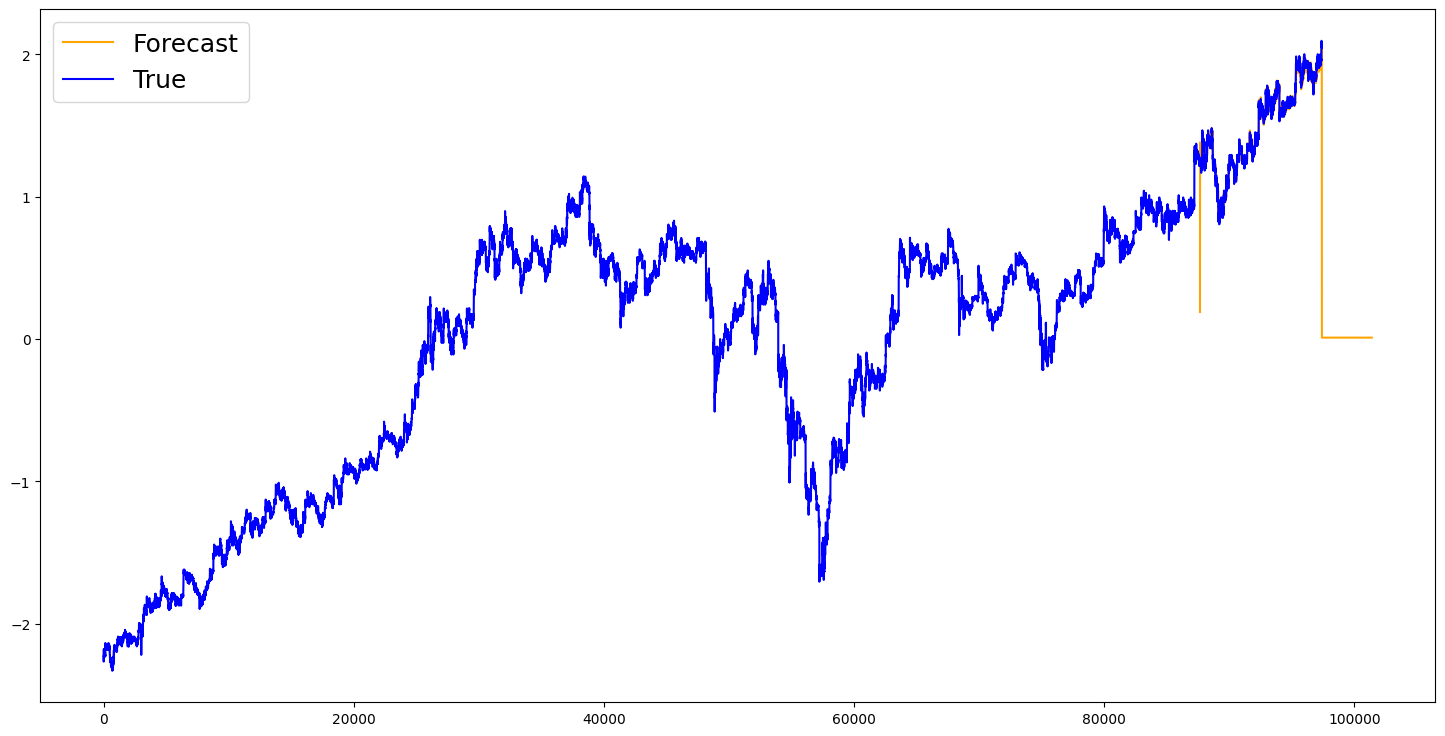

In [9]:
# visualize original data and forecasted data of test data and 4000 next samples
plt.figure(figsize=(18,9))
plt.plot([item+len(XTrain[1])+1 for item in range(len(data_forecast[3]))], data_forecast[3], color='orange', label='Forecast')
plt.plot([item for item in original_total_data[3]], color='b', label='True')
plt.legend(fontsize=18)
plt.show()

In [29]:
XTrain_forVisualize = XTrain[0,:,:]
XTrain_forVisualize = np.transpose(XTrain_forVisualize)

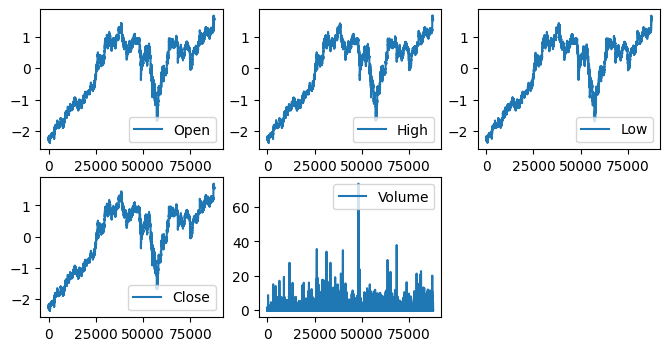

In [32]:
plt.figure(figsize=(8,4))
plt.subplot(2,3,1)
plt.plot(XTrain_forVisualize[0], label='Open')
plt.legend()
plt.subplot(2,3,2)
plt.plot(XTrain_forVisualize[1], label='High')
plt.legend()
plt.subplot(2,3,3)
plt.plot(XTrain_forVisualize[2], label='Low')
plt.legend()
plt.subplot(2,3,4)
plt.plot(XTrain_forVisualize[3], label='Close')
plt.legend()
plt.subplot(2,3,5)
plt.plot(XTrain_forVisualize[4], label='Volume')
plt.legend()
plt.show()